<h1 style="font-size:40px; text-align: center; margin-bottom: 10px;">Detecting AGN migration trap binaries with LISA</h1>
<p style="text-align: center;">Exploring the number of migration trap binaries that can be detected with LISA</p>

In [7]:
import h5py as h5
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const

import os
import sys

# my helper functions
import legwork

sys.path.append("../src/")

from helpers import p_e

%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.7 * fs,
          'ytick.labelsize': 0.7 * fs}
plt.rcParams.update(params)

# Simulation Analysis
I've run 12 simulations with various $\gamma$, $n_{\rm enc}$ and $t_{\rm obs}$ values. Let's check them out.

### Default styles

In [2]:
colour_ef = {
    1: plt.get_cmap("viridis")(0.1),
    3: plt.get_cmap("viridis")(0.5),
    10: plt.get_cmap("viridis")(0.8),
}

# colour_ef = {
#     1: plt.get_cmap("tab20c")(0 / 20),
#     3: plt.get_cmap("tab20c")(4 / 20),
#     10: plt.get_cmap("tab20c")(8 / 20),
# }

width_t = {
    4: 1,
    10: 2
}

style_g = {
    1: "-",
    2: (1, (3, 1, 1, 1))
}

marker_g = {
    1: "o",
    2: "^"
}

## Number of detections

In [3]:
def get_var(varname, g=1, e=10, t=4, filename=None):
    if filename is None:
        filename = "../data/g{}_e{}_t{}.h5".format(g, e, t)
    with h5.File(filename, "r") as file:
        var = file[varname][...]
    return var

In [4]:
def bootstrap_detectable_fraction(snr, sample_size, samples):
    rng = np.random.default_rng()
    bootstrap_samples = rng.choice(a=snr, size=(sample_size, samples))
    detectable_fraction = np.where(bootstrap_samples >= 7, 1, 0).sum(axis=0) / sample_size
    return detectable_fraction

In [5]:
def n_detection(fraction_detectable, ef, max_distance=1 * u.Gpc,
                galaxy_density=4e6 * u.Gpc**(-3), AGN_fraction=0.01):
    sample_volume = max_distance**3
    n_AGN = galaxy_density * sample_volume * AGN_fraction
    fraction_GW_emission = 1 / ef

    n_detection = n_AGN * fraction_GW_emission * fraction_detectable
    return n_detection

2.1093023255813956
1.4500209117524048
2.787760416666667
2.031667839549613
2.140356782228206
1.483628648431676
2.739018087855298
2.099350457632123
2.1992265606117196
1.5210327777694284
2.937065880867186
2.1888214853642736


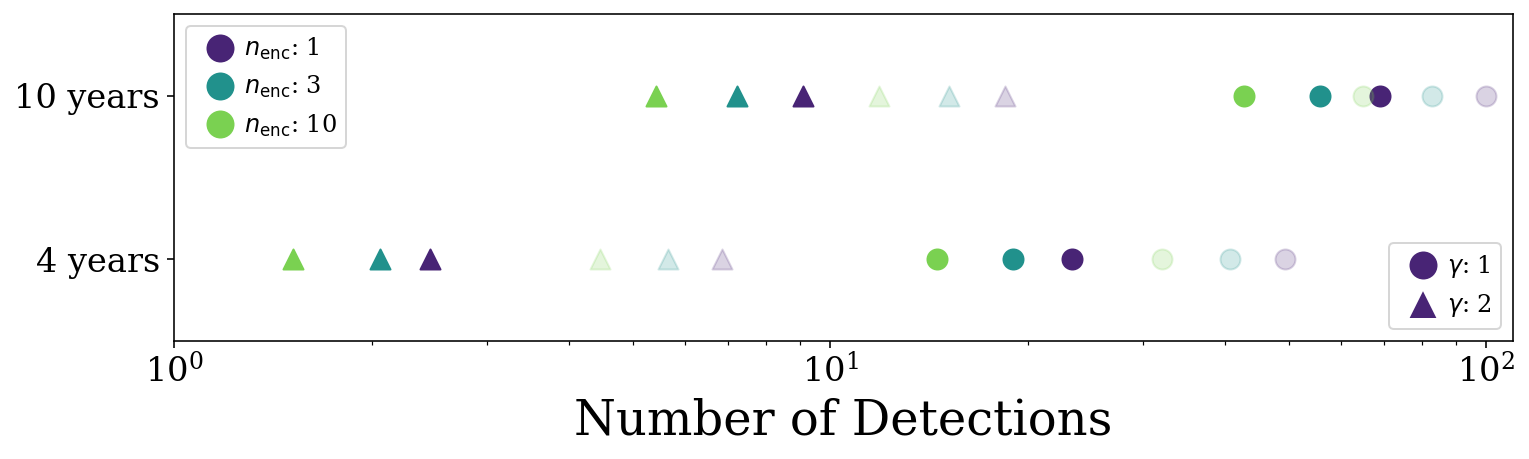

In [46]:
fig,ax = plt.subplots(figsize=(12, 3))

for ef in [1, 3, 10]:
    for gamma in [1, 2]:
        for ml in [4, 10]:
            snr = get_var("snr", g=gamma, e=ef, t=ml)
            detectable = snr > 7
            
            n_detect = n_detection(len(snr[detectable]) / len(snr), ef=ef)
            ax.scatter(n_detect, 1 if ml == 4 else 1.2, color=colour_ef[ef], marker=marker_g[gamma], s=100)
            
            t_merge = get_var("t_e2m", g=gamma, e=ef, t=ml) - get_var("t_se", g=gamma, e=ef, t=ml)
            maybe_detectable = np.logical_or(snr > 7, np.logical_and(snr > 4, t_merge < 20))
            
            n_maybe_detect = n_detection(len(snr[maybe_detectable]) / len(snr), ef=ef)
            print(n_maybe_detect / n_detect)
            ax.scatter(n_maybe_detect, 1 if ml == 4 else 1.2, color=colour_ef[ef],
                       marker=marker_g[gamma], s=100, alpha=0.2)
            
            
ax.set_ylim(0.9, 1.3)

ax.set_xscale("log")
ax.set_xlim(1, 110)

ax.set_yticks([1, 1.2])
ax.set_yticklabels(["4 years", "10 years"])

ax.set_xlabel("Number of Detections")

legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label=r'$n_{\rm enc}$: 1',
                                           markerfacecolor=colour_ef[1], markersize=15),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label=r'$n_{\rm enc}$: 3',
                                           markerfacecolor=colour_ef[3], markersize=15),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label=r'$n_{\rm enc}$: 10',
                                           markerfacecolor=colour_ef[10], markersize=15)]
legend = ax.legend(handles=legend_elements, handletextpad=0, fontsize=0.5*fs)
ax.add_artist(legend)

legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label=r'$\gamma$: 1',
                                           markerfacecolor=colour_ef[1], markersize=15),
                   matplotlib.lines.Line2D([0], [0], marker='^', color='w', label=r'$\gamma$: 2',
                                           markerfacecolor=colour_ef[1], markersize=15)]
ax.legend(handles=legend_elements, handletextpad=0, fontsize=0.5*fs, loc='lower right')

plt.savefig("../plots/detections.png", bbox_inches="tight", dpi=400)
plt.savefig("../plots/detections.pdf", format="pdf", bbox_inches="tight")
    
plt.show()

In [9]:
for ef in [1, 3, 10]:
    table_line = r"{{{}}} & ".format(ef)
    for gamma in [1, 2]:
        for ml in [4, 10]:
            snr = get_var("snr", g=gamma, e=ef, t=ml)
            n_detect = n_detection(bootstrap_detectable_fraction(snr, 500000, 1000), ef=ef)
            table_line = table_line + r"${{{:1.1f}}} \pm {{{:1.1f}}}$ & ".format(n_detect.mean(), n_detect.std() * 2)
    print(table_line[:-2] + "\\\\")

KeyboardInterrupt: 

## Detectable population plots

In [22]:
def plot_detectable_var(var, filename, log_scale=False, xlabel=None, ylabel=None, xlim=None, ylim=None, show=True):
    fig, ax = plt.subplots()
    for g in [1, 2]:
        for e in [1, 3, 10]:
            for t in [4, 10]:
                detectable = get_var("snr", g, e, t) > 7
                sns.kdeplot(get_var(var, g, e, t)[detectable], color=colour_ef[e], linestyle=style_g[g],
                            lw=width_t[t], log_scale=log_scale, ax=ax)
    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
        
    if ylabel is not None:
        ax.set_ylabel(ylabel)
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    plt.savefig("../plots/" + filename + ".png", bbox_inches="tight", dpi=400)
    plt.savefig("../plots/" + filename + ".pdf", format="pdf", bbox_inches="tight")
    
    if show:
        plt.show()
        
    return fig, ax

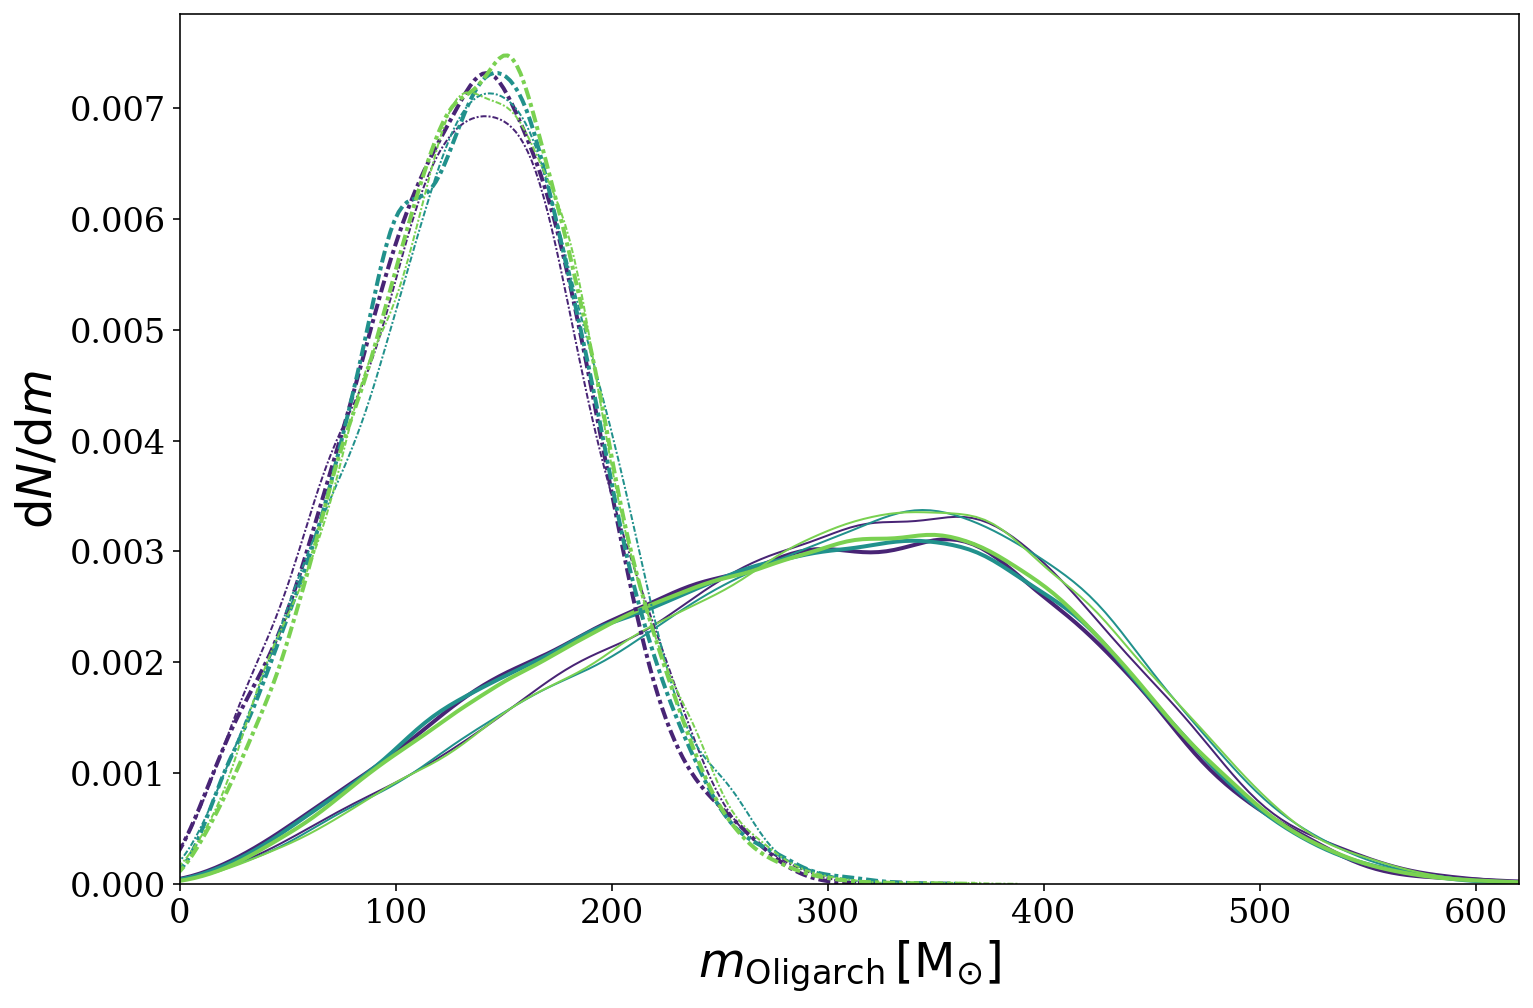

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='$m_{\\rm Oligarch} \\, [\\rm M_{\\odot}]$', ylabel='$\\mathrm{d} N / \\mathrm{d} m$'>)

In [11]:
plot_detectable_var("m_1", "m_oligarch", xlabel=r"$m_{\rm Oligarch} \, [\rm M_{\odot}]$", ylabel=r"$\mathrm{d} N / \mathrm{d} m$", xlim=(0, 620))

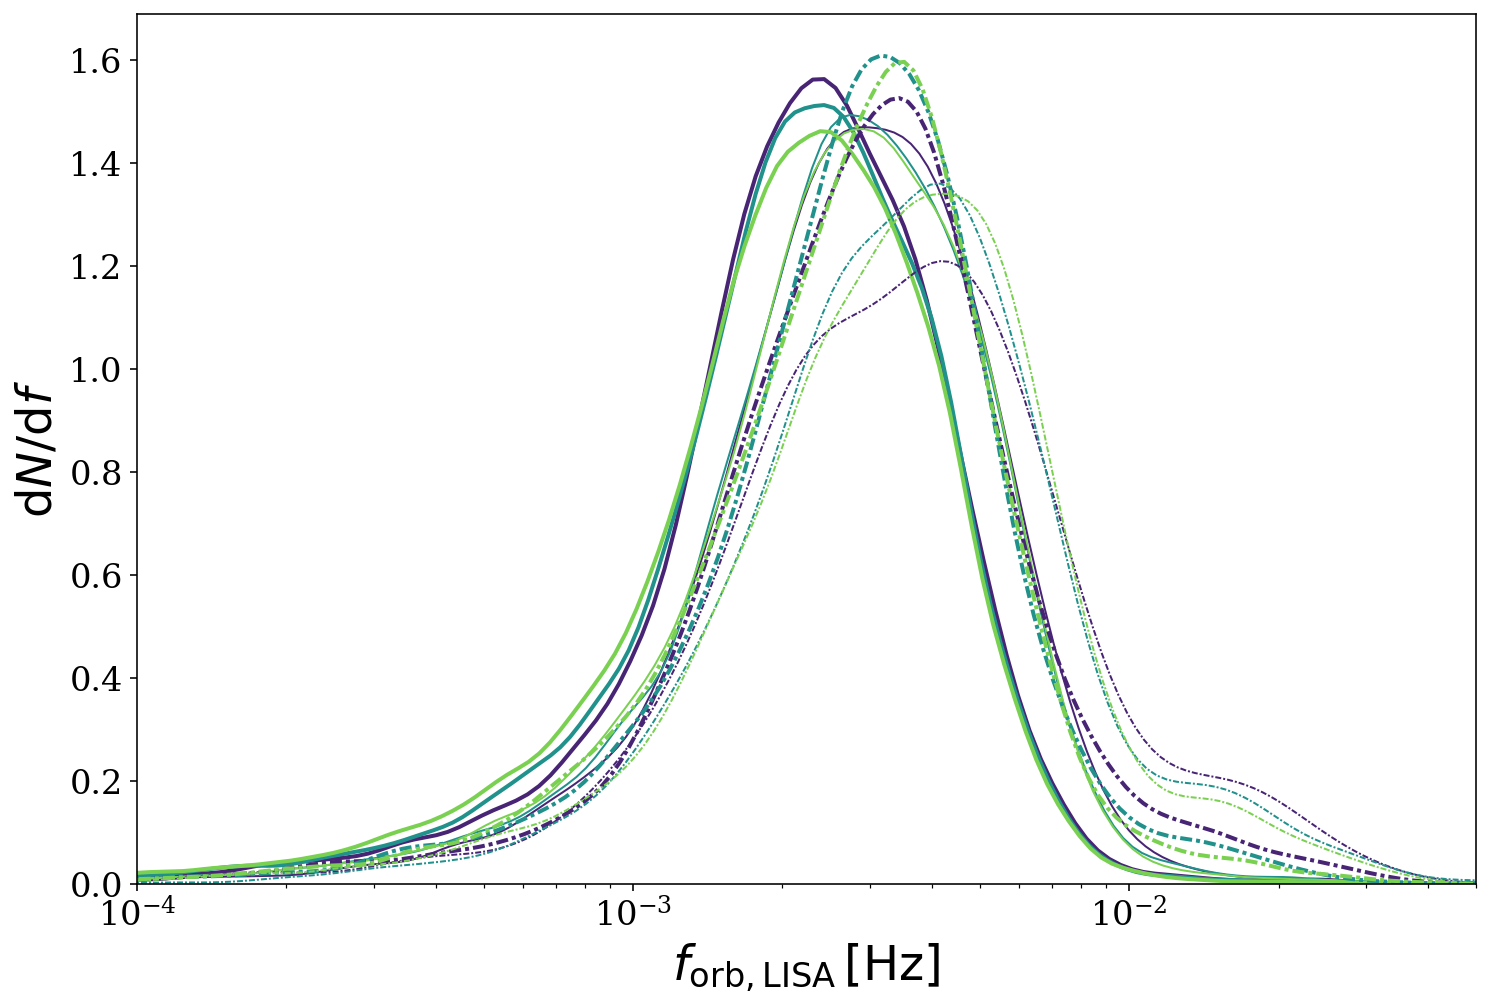

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='$f_{\\rm orb, LISA} \\, [\\rm Hz]$', ylabel='$\\mathrm{d} N / \\mathrm{d} f$'>)

In [12]:
plot_detectable_var("f_orb_LISA", "f_orb_LISA", xlabel=r"$f_{\rm orb, LISA} \, [\rm Hz]$", ylabel=r"$\mathrm{d} N / \mathrm{d} f$", xlim=(1e-4, 5e-2), log_scale=True)

0.24563022777373855
0.2845816612583499
0.2831704061359478
0.31994146266865886
0.3196227034565529
0.3642581895286327
0.22679855505405774
0.23946138746302748
0.25046636304060765
0.2826806586772902
0.2844817597929054
0.32333549519315447


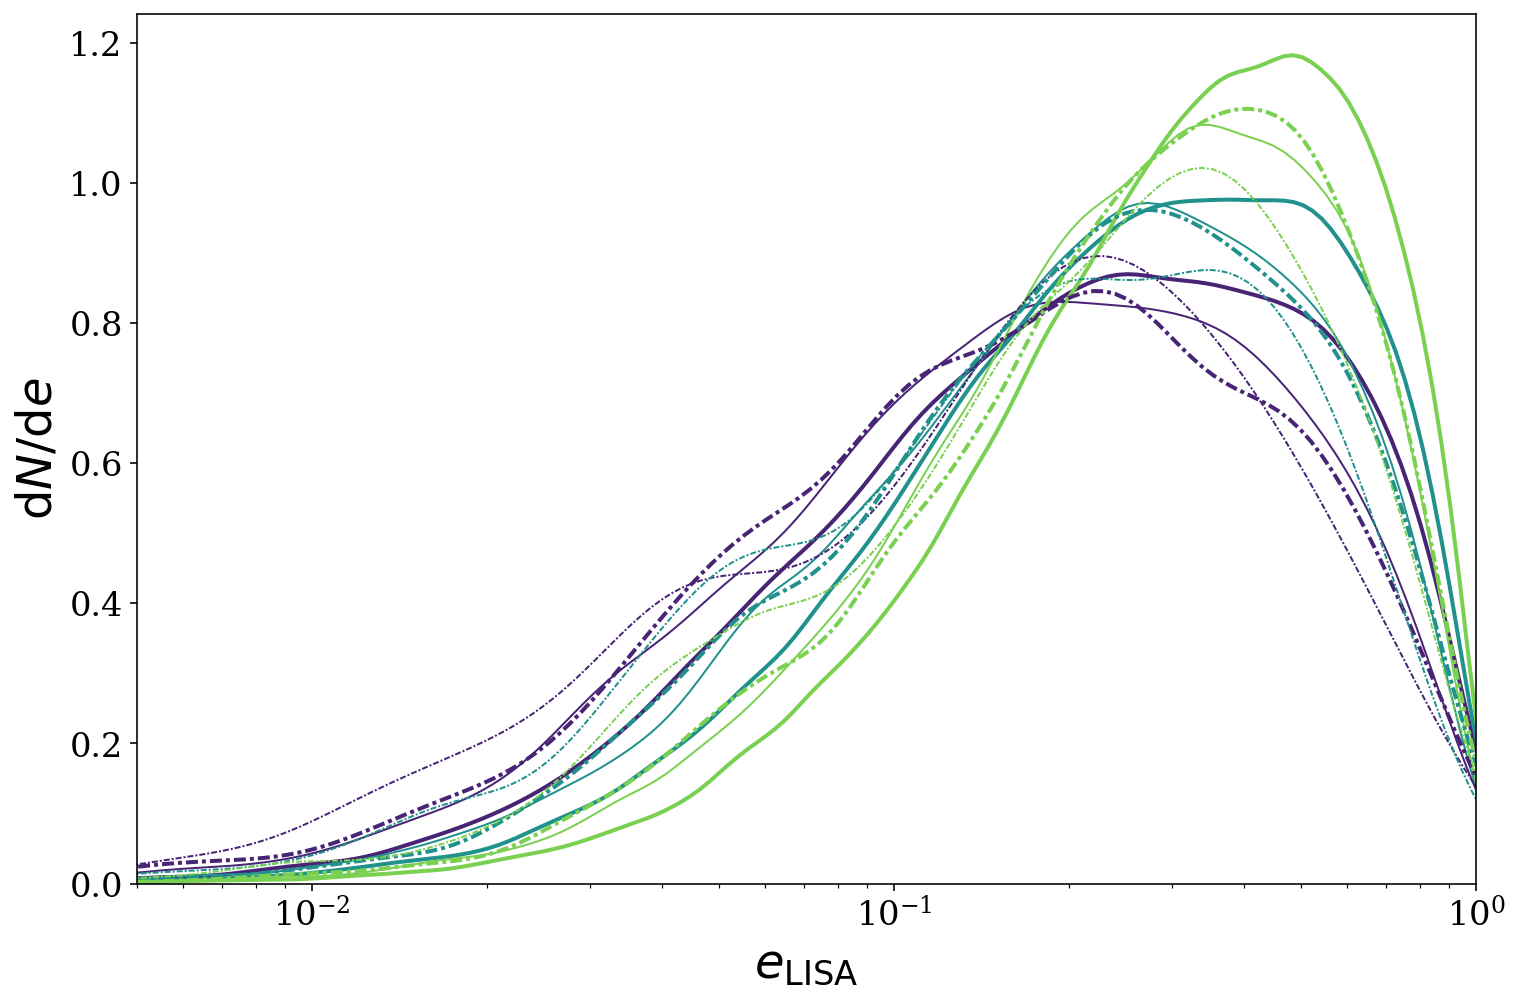

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='$e_{\\rm LISA}$', ylabel='$\\mathrm{d} N / \\mathrm{d} e$'>)

In [23]:
plot_detectable_var("e_LISA", "e_LISA", xlabel=r"$e_{\rm LISA}$", ylabel=r"$\mathrm{d} N / \mathrm{d} e$", xlim=(5e-3, 1), log_scale=True)

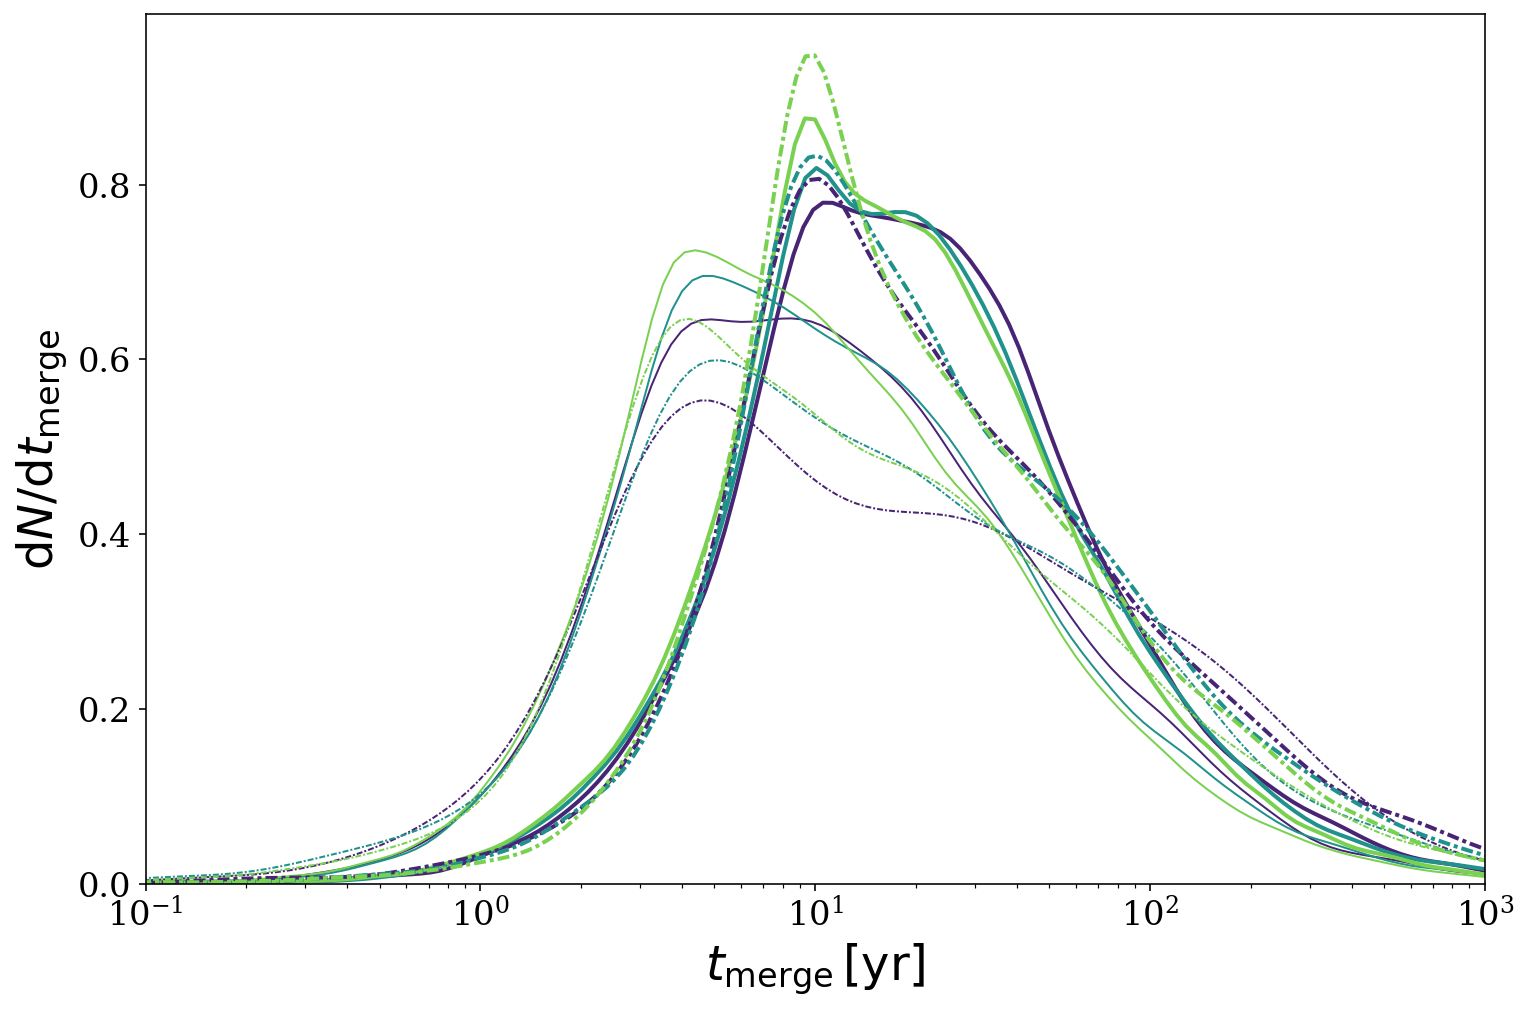

In [14]:
for g in [1, 2]:
    for e in [1, 3, 10]:
        for t in [4, 10]:
            detectable = get_var("snr", g, e, t) > 7
            t_merge = get_var("t_e2m", g, e, t) - get_var("t_se", g, e, t)
            sns.kdeplot(t_merge[detectable], color=colour_ef[e], linestyle=style_g[g], lw=width_t[t], log_scale=True)
plt.xlim(1e-1, 1e3)

plt.xlabel(r"$t_{\rm merge} \, [\rm yr]$")
plt.ylabel(r"$\mathrm{d} N / \mathrm{d} t_{\rm merge}$")

plt.savefig("../plots/t_merge.png", dpi=400, bbox_inches="tight")
plt.savefig("../plots/t_merge.pdf", format="pdf", bbox_inches="tight")

plt.show()

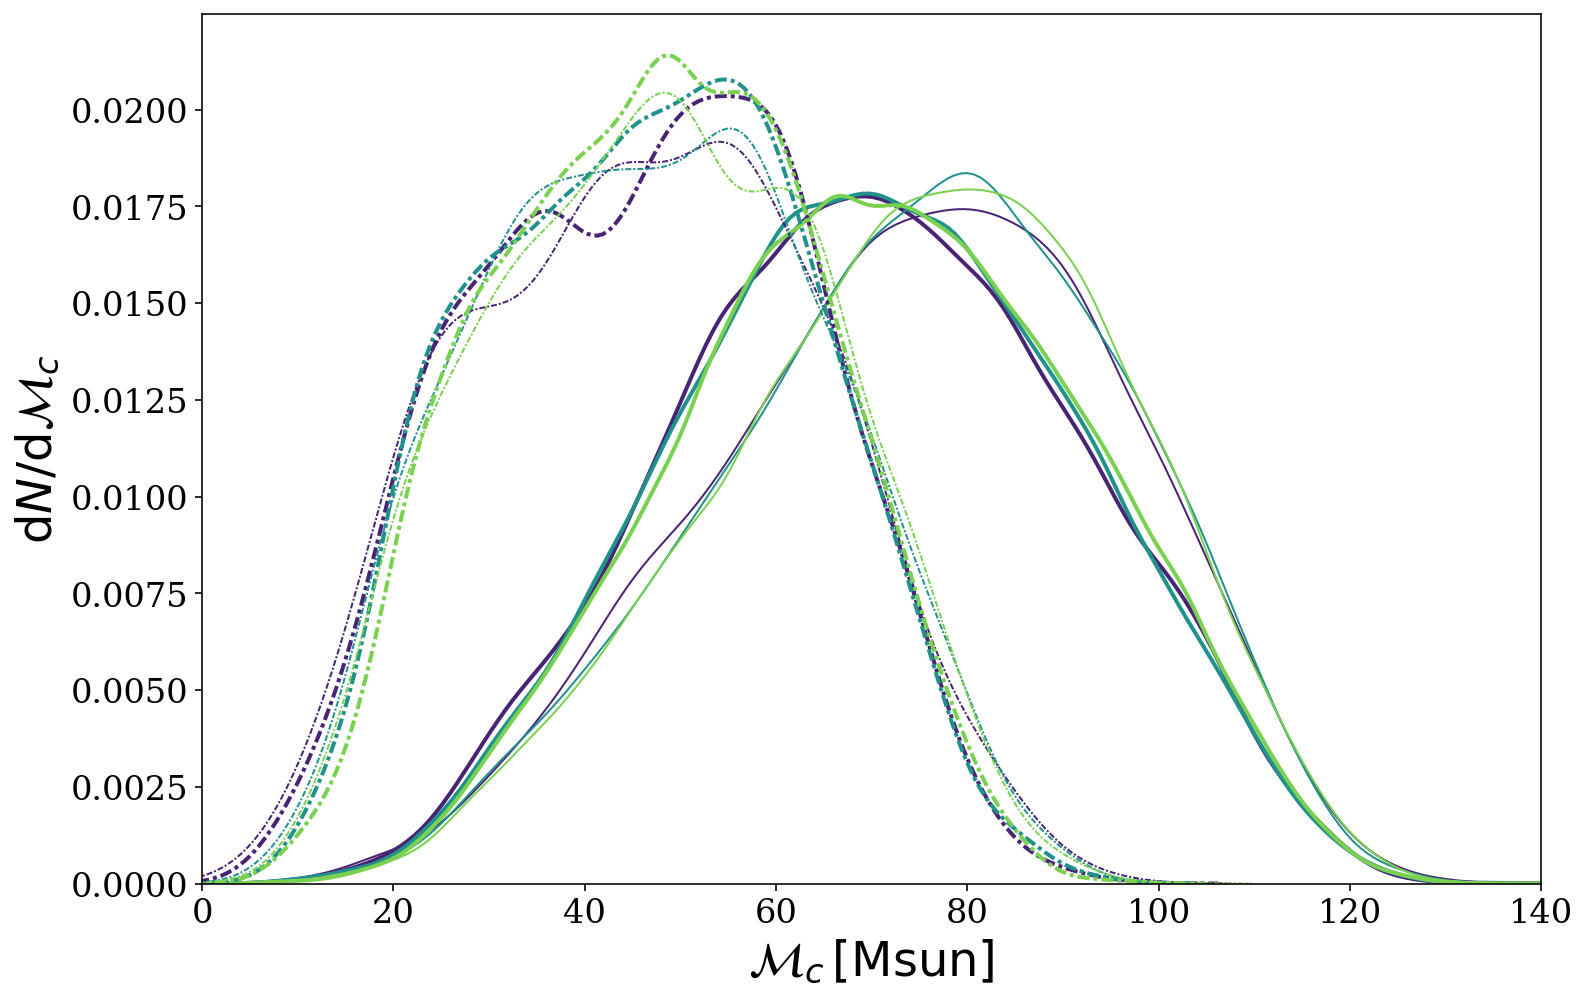

In [15]:
for g in [1, 2]:
    for e in [1, 3, 10]:
        for t in [4, 10]:
            detectable = get_var("snr", g, e, t) > 7
            m_c = legwork.utils.chirp_mass(get_var("m_1", g, e, t), get_var("m_2", g, e, t))
            sns.kdeplot(m_c[detectable], color=colour_ef[e], linestyle=style_g[g], lw=width_t[t])
plt.xlim(0, 140)

plt.xlabel(r"$\mathcal{M}_c \, [\rm Msun]$")
plt.ylabel(r"$\mathrm{d} N / \mathrm{d} \mathcal{M}_c$")

plt.savefig("../plots/m_c.png", dpi=400, bbox_inches="tight")
plt.savefig("../plots/m_c.pdf", format="pdf", bbox_inches="tight")

plt.show()

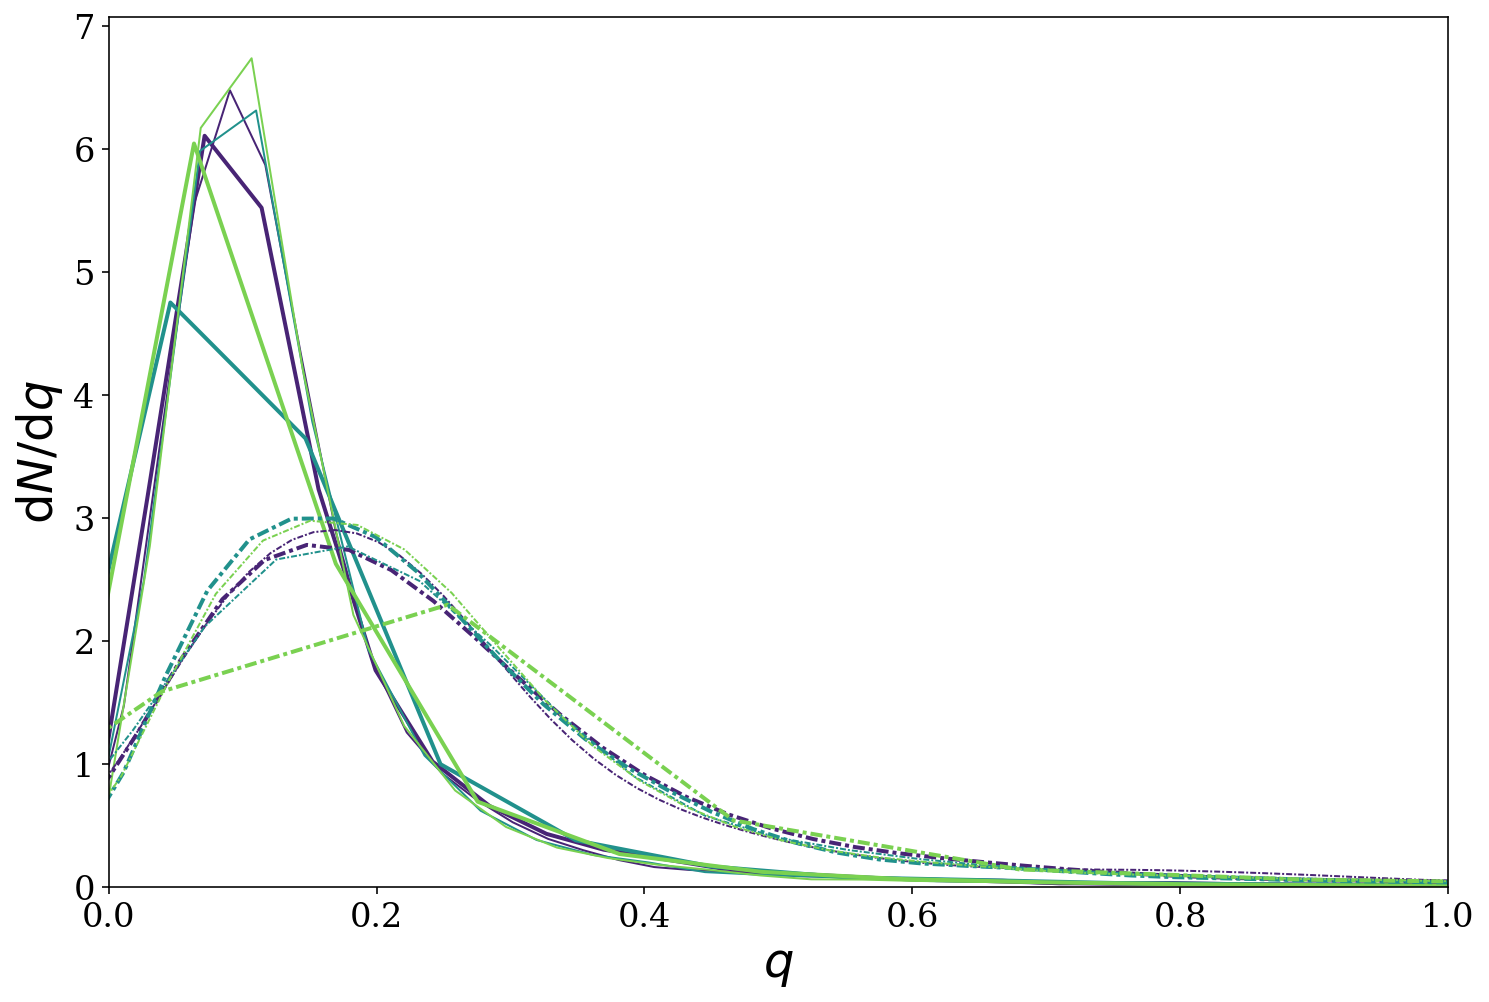

In [17]:
for g in [1, 2]:
    for e in [1, 3, 10]:
        for t in [4, 10]:
            detectable = get_var("snr", g, e, t) > 7
            q = get_var("m_2", g, e, t) / get_var("m_1", g, e, t)
            sns.kdeplot(q[detectable], color=colour_ef[e], linestyle=style_g[g], lw=width_t[t])
plt.xlim(0, 1)

plt.xlabel(r"$q$")
plt.ylabel(r"$\mathrm{d} N / \mathrm{d} q$")

plt.savefig("../plots/q.png", dpi=400, bbox_inches="tight")
plt.savefig("../plots/q.pdf", format="pdf", bbox_inches="tight")

plt.show()

0.46906211920387064
0.5333795458013076
0.46940656232047717
0.536982163773448
0.4751039581227748
0.5444546874588427
0.3048220216468042
0.3955219179015444
0.3119275837940912
0.3946337718836409
0.31694553172735507
0.3965445438988569


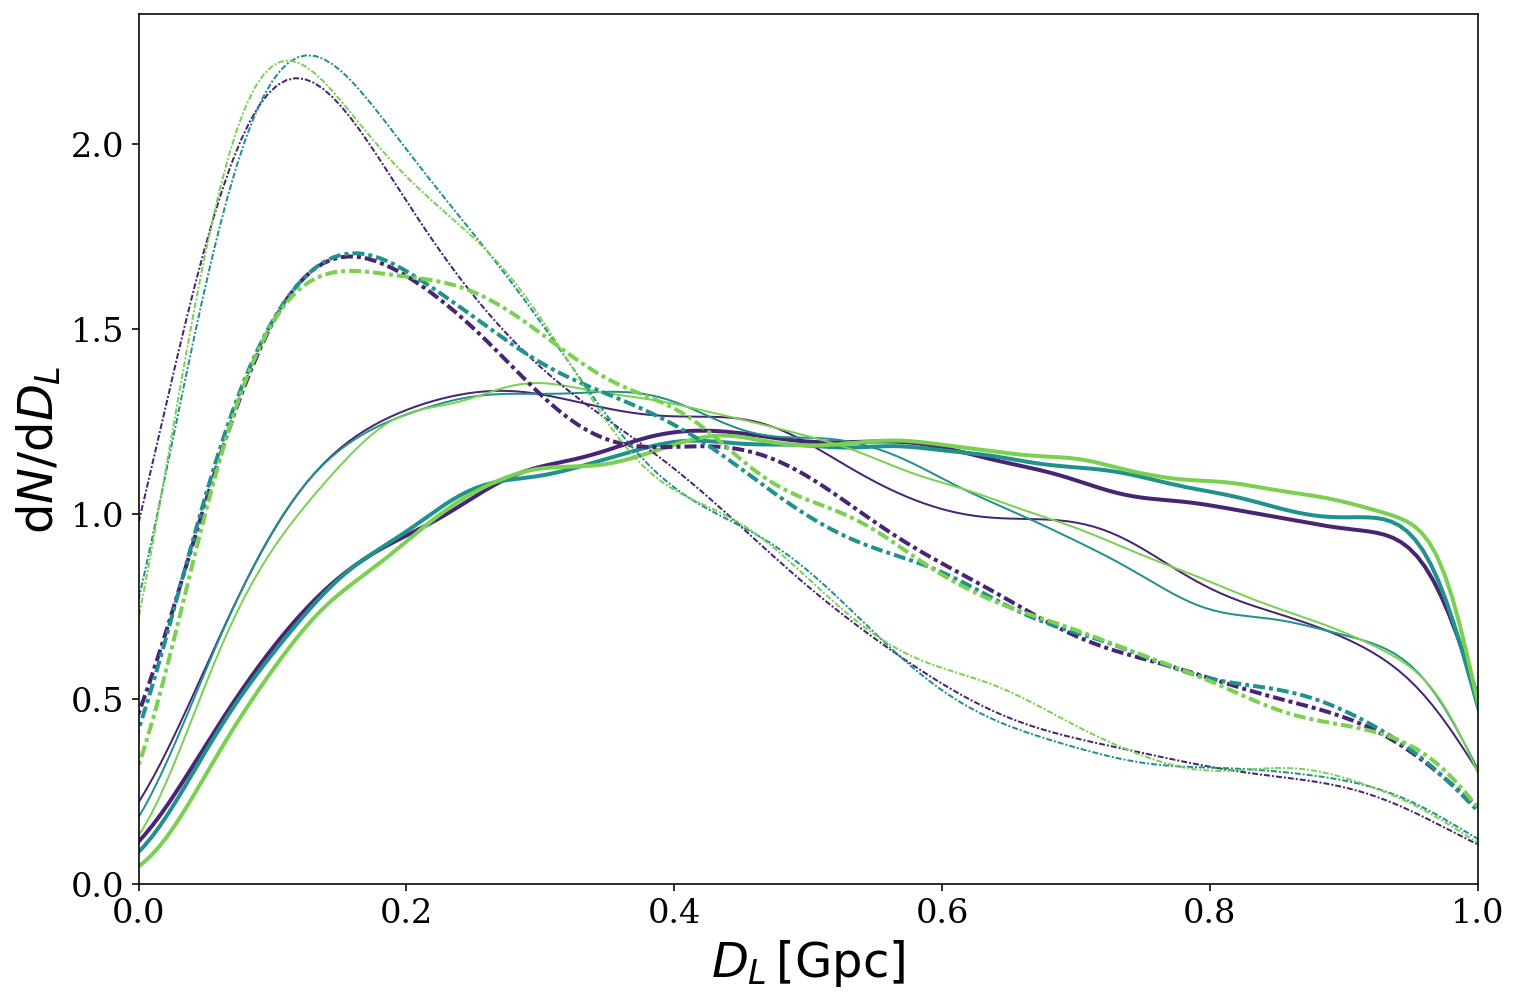

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='$D_L \\, [\\rm Gpc]$', ylabel='$\\mathrm{d} N / \\mathrm{d} D_L$'>)

In [65]:
plot_detectable_var("dist", "dist", xlabel=r"$D_L \, [\rm Gpc]$", ylabel=r"$\mathrm{d} N / \mathrm{d} D_L$", xlim=(0, 1))

## Uncertainties

In [48]:
def sky_localisation(snr, fGW, L=2*u.AU):
    sigma_theta = 16.6 * (7 / snr) * (5e-4 * u.Hz / fGW) * (2 * u.AU / L) * u.deg
    return sigma_theta.to(u.deg)

def f_uncertainty(snr, t_obs, f):
    return (4 * np.sqrt(3) / np.pi / (snr * t_obs) / f).decompose()

def fdot_uncertainty(snr, t_obs, fdot):
    return (6 * np.sqrt(5) / np.pi / (snr * t_obs**2) / fdot).decompose()

def Fprime_over_F(e):
    return e * (1256 + 1608 * e**2 + 111 * e**4) / (96 + 196 * e**2 - 255 * e**4 - 37 * e**6)